## Σε αυτό το σημείο της εργασίες πρέπει να συγκρίνουμε τα 3 pipelines που χρησιμοποιήσαμε στο ερώτημα 1Β μεταξύ τους

### Βήματα 
- Διαβάζουμε τα 3 ανακατσκευασμένα κείμενα
- Κάνουμε σύγκριση

In [1]:
def take_files(path):  
    try:
        with open(path, 'r', encoding='utf-8') as file:
            print("File content successfully loaded.")
            return file.read()
    except FileNotFoundError:
        print("Error: The file  was not found. Please make sure the file exists and the path is correct.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [2]:
paths=["../text_files/text2.txt","../text_files/first_pipeline_text2.txt","../text_files/second_pipeline_text2.txt","../text_files/third_pipeline_text2.txt"]
texts=[]
for path in paths:
    texts.append(take_files(path))
original_text=texts[0]
pipeline1=texts[1]
pipeline2=texts[2]
pipeline3=texts[3]



File content successfully loaded.
File content successfully loaded.
File content successfully loaded.
File content successfully loaded.


## Ground truth κείμενο από το gemini

In [3]:
gemini = """During our last discussion, I mentioned the new submission we have been waiting for since last autumn, noting that the recent updates were confusing because they appeared to be missing the full feedback from either the reviewer or the editor. Despite some recent delays and a lack of communication, I firmly believe the team tried their absolute best and cooperated effectively, and we should all be grateful for their efforts which led to the paper's acceptance, finalized by the Springer link that arrived last week. Regarding the final steps, could you please remind me if the doctor still plans to edit the acknowledgments section before sending the paper again? I have not seen a final version of that part, though I apologize if I simply missed it. Let's ensure everyone is doing well, celebrate this successful outcome, and begin planning our future targets."""

## Ground truth κείμενο απο το deepseek

In [4]:
deepseek = """During our final discussion, I informed him about the new paper submission—the one we had been anticipating since last autumn. However, the recent updates regarding this submission were confusing, as they did not appear to include the reviewers' full feedback, or possibly the editor's comments. Despite the recent delays and reduced communication from the team, I believe they genuinely put forth their best effort for the paper and our collaboration. Consequently, we should all be grateful for the paper's acceptance and the team's persistent work, especially now that the Springer link has finally become available last week. Also, please remind me if the doctor still plans to make edits to the acknowledgments section before he resubmits it, as I haven't seen the final version of that part yet—I apologize if I missed it. Overall, let's ensure everything is finalized, and then celebrate this outcome with strong coffee and discussions about future targets."""

## Ground truth κείμενο απο το chat gpt

In [5]:
chat_gpt="""During our final discussion, I updated him on the new submission we’ve been awaiting since last autumn. Although the most recent update was confusing—because it did not include the full reviewer or editor feedback—I believe our team, despite some delays and reduced communication lately, has been fully committed to the paper and to cooperating throughout the process. We should all be grateful for their hard work and for the acceptance, and I was pleased to see the Springer link finally go live last week. Please remind me whether the doctor still plans to edit the acknowledgments section before sending the final version again, as I have not yet seen it; I apologize if I missed it. Overall, let’s make sure everything is in order, celebrate this success with strong coffee, and set our sights on future goals."""

## Word Embeddings + συναρτήσεις που θα χρειαστούμε

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import numpy as np

def create_skip_grams(words, window_size=2):
    skip_grams = []
    for i, word in enumerate(words):
        context_words = words[max(0, i - window_size): i] + words[i + 1: i + window_size + 1]
        for context_word in context_words:
            skip_grams.append((word, context_word))
    return skip_grams

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size) # Σωστά ορισμένο ως output_layer
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        output = self.output_layer(embeds) 
        return output
def cosine_similarity(vec1, vec2):
    """
    Υπολογίζει την ομοιότητα συνημιτόνου μεταξύ δύο NumPy διανυσμάτων.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0 # Αποφυγή διαίρεσης με το μηδέν
    
    return dot_product / (norm_vec1 * norm_vec2)

def get_paragraph_embedding(paragraph, model, word_to_idx_map): # Άλλαξα το όνομα παραμέτρου για σαφήνεια
    """
    Δημιουργεί ένα ενιαίο διάνυσμα (embedding) για μια παράγραφο
    κάνοντας τον μέσο όρο των embeddings των λέξεων που την απαρτίζουν.
    Χρησιμοποιεί το embedding layer από το δικό σας μοντέλο.
    """
    tokens = [word.lower() for word in word_tokenize(paragraph)]
    
    word_ids = []
    for word in tokens:
        if word in word_to_idx_map: # Χρησιμοποιούμε το word_to_idx_map
            word_ids.append(word_to_idx_map[word])
    
    if not word_ids:
        return np.zeros(model.embeddings.embedding_dim)
    
    input_tensor = torch.tensor(word_ids, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        word_embeds = model.embeddings(input_tensor)
    
    paragraph_embedding = torch.mean(word_embeds, dim=1).squeeze(0)
    
    return paragraph_embedding.numpy()

## Εκπαίδευση μοντέλου στο σύνολο των τριών κειμένων

In [7]:
train_data=pipeline1+pipeline2+pipeline3

words = train_data.split()

word_to_ix = {word: i for i, word in enumerate(set(words))}
ix_to_word = {i: word for i, word in enumerate(set(words))}
vocab_size = len(word_to_ix)

embedding_dim = 10 

model = Word2Vec(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  

pairs = create_skip_grams(words)
n_epochs= 50 

for epoch in range(n_epochs):
    total_loss  = 0 
    for word, context in pairs:
        model.zero_grad()
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        context_idx = torch.tensor([word_to_ix[context]], dtype=torch.long)
        
        output = model(word_idx)
        loss = criterion(output, context_idx)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

    #Get word vectors 
    word_vectors = {}
    for word in word_to_ix:
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        word_vectors[word] = model.embeddings(word_idx).detach().numpy()

Epoch 0, Loss: 12445.964832544327
Epoch 10, Loss: 9919.085149407387
Epoch 20, Loss: 9044.129181981087
Epoch 30, Loss: 8381.744369506836
Epoch 40, Loss: 7883.681665062904


In [8]:
embedding_original = get_paragraph_embedding(original_text, model, word_to_ix)
embedding_pipeline1 = get_paragraph_embedding(pipeline1, model, word_to_ix)
embedding_pipeline2 = get_paragraph_embedding(pipeline2, model, word_to_ix)
embedding_pipeline3 = get_paragraph_embedding(pipeline3, model, word_to_ix)

In [9]:
embedding_chat_gpt = get_paragraph_embedding(chat_gpt, model, word_to_ix)
embedding_gemini = get_paragraph_embedding(gemini, model, word_to_ix)
embedding_deepseek = get_paragraph_embedding(deepseek, model, word_to_ix)

In [10]:
print("\n--- Original Text vs Pipelines (Word Embeddings) ---")
sim_orig_p1_we = cosine_similarity(embedding_original, embedding_pipeline1)
print(f"Original Text vs Pipeline 1: {sim_orig_p1_we:.4f}")

sim_orig_p2_we = cosine_similarity(embedding_original, embedding_pipeline2)
print(f"Original Text vs Pipeline 2: {sim_orig_p2_we:.4f}")

sim_orig_p3_we = cosine_similarity(embedding_original, embedding_pipeline3)
print(f"Original Text vs Pipeline 3: {sim_orig_p3_we:.4f}")


--- Original Text vs Pipelines (Word Embeddings) ---
Original Text vs Pipeline 1: 0.9666
Original Text vs Pipeline 2: 0.9782
Original Text vs Pipeline 3: 0.8413


## Ground Truth LLM Texts vs Pipelines (Word Embeddings)

In [11]:
print("\nChatGPT vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline1)
print(f"ChatGPT vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline2)
print(f"ChatGPT vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline3)
print(f"ChatGPT vs Pipeline 3: {sim_gpt_p3_we:.4f}")


ChatGPT vs Pipelines:
ChatGPT vs Pipeline 1: 0.9351
ChatGPT vs Pipeline 2: 0.9517
ChatGPT vs Pipeline 3: 0.7997


In [12]:
print("\n Gemini vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_gemini, embedding_pipeline1)
print(f"Gemini vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_gemini, embedding_pipeline2)
print(f"Gemini vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_gemini, embedding_pipeline3)
print(f"Gemini vs Pipeline 3: {sim_gpt_p3_we:.4f}")


 Gemini vs Pipelines:
Gemini vs Pipeline 1: 0.8846
Gemini vs Pipeline 2: 0.8892
Gemini vs Pipeline 3: 0.8712


In [13]:
print("\nDeepseek vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_deepseek, embedding_pipeline1)
print(f"ChatGPT vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_deepseek, embedding_pipeline2)
print(f"ChatGPT vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_deepseek, embedding_pipeline3)
print(f"ChatGPT vs Pipeline 3: {sim_gpt_p3_we:.4f}")


Deepseek vs Pipelines:
ChatGPT vs Pipeline 1: 0.9134
ChatGPT vs Pipeline 2: 0.9126
ChatGPT vs Pipeline 3: 0.7588


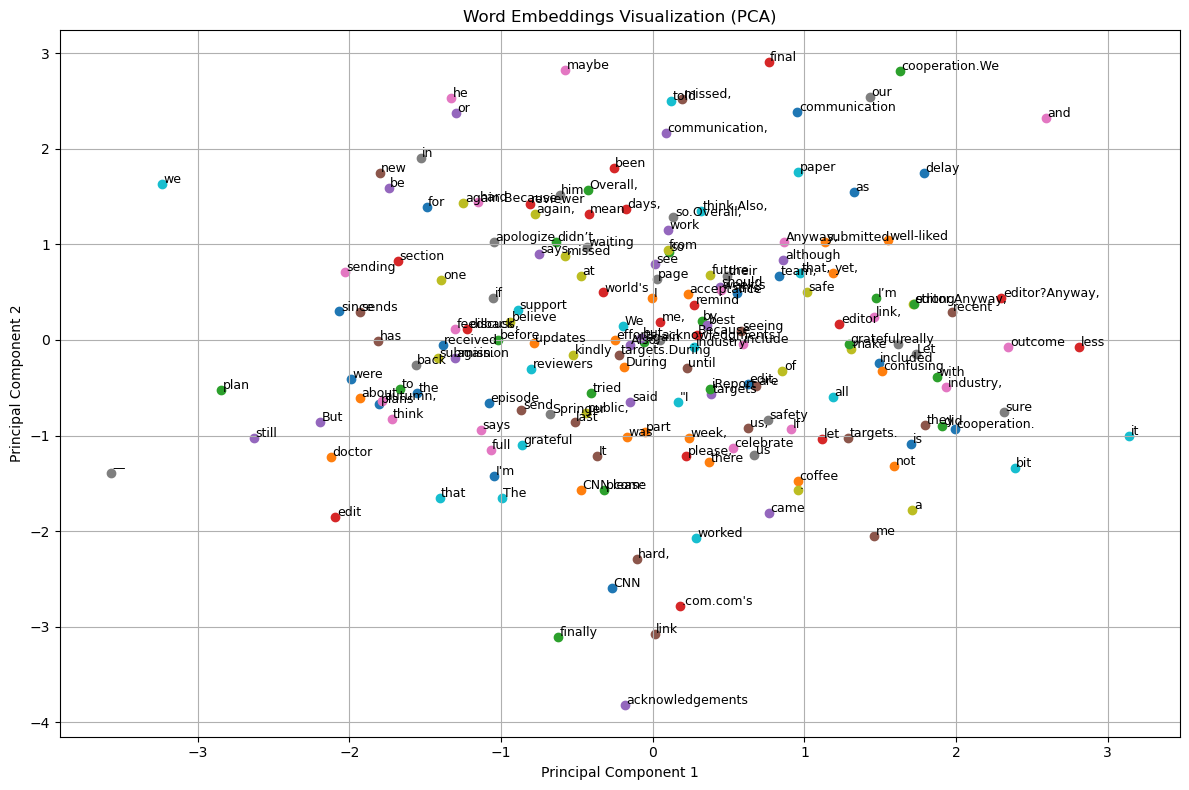

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Συγκεντρώνουμε όλα τα word embeddings σε ένα array
labels = []
vectors = []

for word, idx in word_to_ix.items():
    word_tensor = torch.tensor([idx], dtype=torch.long)
    embedding = model.embeddings(word_tensor).detach().numpy()[0]
    labels.append(word)
    vectors.append(embedding)

vectors = np.array(vectors)

# Μείωση διάστασης με PCA σε 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

plt.title("Word Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
